# Summary

We want a simple figure demonstrating the MBGP fit on 4 gene data.

# Helper definitions

In [1]:
from BranchedGP.MBGP.data_generation import ToyBranchedData, GeneExpressionData
from BranchedGP.MBGP.training_helpers import TrainingOutcome, get_training_outcome
from BranchedGP.MBGP.plotting_helpers import plot_detailed_fit, plot_model_snapshot
from BranchedGP.MBGP.sampling_helpers import get_synthetic_noisy_branched_data

from BranchedGP.MBGP.assigngp import AssignGP
from BranchedGP.MBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np

from BranchedGP.MBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow
from typing import Sequence

from BranchedGP.MBGP.data_generation import Vector
from BranchedGP.MBGP.training_helpers import InitialAndPriorPhi, PhiConstructor


def get_assigngp_with_target_bps(bps: Sequence[float], lengthscale: float, noise_variance: float) -> AssignGP:
    """ A simple wrapper that tweaks some key model construction parameters. """
    data = ToyBranchedData(bps, N=100)  # not used; need data to construct a model
    m = construct_assigngp_model(
        gene_expression=data,
        phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
        initial_branching_points=[0.5]*data.num_genes,
    )
    
    # assign reasonable initial values for the BPs
    m.kernel.Bv.assign(np.array(bps))
    m.kernel.kern.lengthscales.assign(lengthscale)
    m.likelihood.variance.assign(noise_variance)
    return m



def get_funky_phi(
        global_branching_state: Vector,
        uninformative_until: float,
        informative_prior_confidence: float,
) -> InitialAndPriorPhi:
    if not 0 <= uninformative_until <= 1:
        raise ValueError(
            f"Expected uninformative_until to be in the range [0, 1]. "
            f"Instead got: {uninformative_until}."
        )
    if not 0 <= informative_prior_confidence <= 1:
        raise ValueError(
            f"Expected informative_prior_confidence to be in the range [0, 1]. "
            f"Instead got: {uninformative_until}."
        )

    (N,) = global_branching_state.shape
    # WARNING: assumes uniformly spaced state on [0, 1].
    uninformative_until_idx = int(uninformative_until * N)
    print(f"Uninformative until idx: {uninformative_until_idx}")

    # Initialise phi_initial and phi_prior to 50% probability for each of the branches g, h
    # We will then update them
    phi_initial = np.ones((N, 2)) * 0.5
    phi_prior = np.ones((N, 2)) * 0.5

    # TODO: the following can probably be written as pure numpy array operations,
    #   but we're taking the easy way for speed.
    for i in range(N):
        not_trunk = global_branching_state[i] in {2, 3}

        if not_trunk:
            # The g, h states normally map to 2, 3, but here we want to map them to columns 0, 1
            true_branch_col = int(global_branching_state[i] - 2)
            if i > uninformative_until_idx:
                phi_prior[i, :] = 1 - informative_prior_confidence
                phi_prior[i, true_branch_col] = informative_prior_confidence
            # else leave at 0.5, 0.5

            # Set phi_initial to have true state label with a random probability in [0.5, 1]
            # This is the same as SimplePhiConstructor
            phi_initial[i, true_branch_col] = 0.5 + (np.random.random() / 2.)
            phi_initial[i, true_branch_col != np.array([0, 1])] = 1 - phi_initial[i, true_branch_col]

    assert np.allclose(phi_prior.sum(1), 1), \
        f"Phi Prior probability distribution should sum to 1 for each branch. " \
        f"Instead got: {phi_prior.sum(1)}"
    assert np.allclose(phi_initial.sum(1), 1), \
        f"Phi Initial probability distribution should sum to 1 for each branch. " \
        f"Instead got: {phi_initial.sum(1)}"
    assert np.all(~np.isnan(phi_initial)), f"Found NaNs in phi_initial, something has gone badly wrong!"
    assert np.all(~np.isnan(phi_prior)), f"Found NaNs in phi_prior, something has gone badly wrong!"
    return phi_initial, phi_prior


class FunkyPrior(PhiConstructor):
    """
    Uninformative prior for early cells, informative prior for late cells.
    """

    def __init__(
            self,
            gene_expression_data: GeneExpressionData,
            uninformative_until: float,
            informative_prior_confidence: float,
            allow_infs: bool = True,
    ) -> None:
        self._state = gene_expression_data.state
        self._uninformative_until = uninformative_until
        self._informative_prior_confidence = informative_prior_confidence
        self._allow_infs = allow_infs

    def build(self) -> InitialAndPriorPhi:
        phi_initial, phi_prior = get_funky_phi(
            global_branching_state=self._state,
            uninformative_until=self._uninformative_until,
            informative_prior_confidence=self._informative_prior_confidence,
        )

        phi_prior = np.c_[np.zeros(phi_prior.shape[0])[:, None], phi_prior]  # prepend 0 for trunk
        return phi_initial, phi_prior

## Sample, fit and plot

Metal device set to: Apple M1
10 samples drawn, 0 valid samples constructed
Uninformative until idx: 80


2023-05-10 14:23:28.808718: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


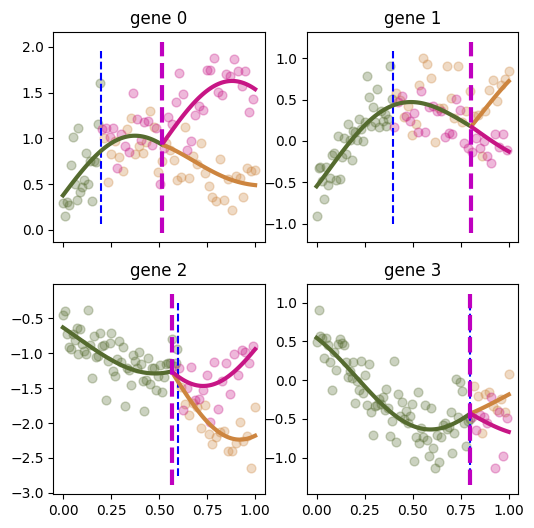

In [2]:
from BranchedGP.MBGP.training_helpers import fixed_bps


NOISE = 0.05
LENGTHSCALE = 0.5

TRUE_BPS = [0.2, 0.4, 0.6, 0.8]


HIGH_PRIOR_CONFIDENCE = 0.8

dummy_model = get_assigngp_with_target_bps(
    TRUE_BPS, 
    lengthscale=LENGTHSCALE, 
    noise_variance=NOISE,
)
data = get_synthetic_noisy_branched_data(
    dummy_model, 
    num_samples=1, 
    x_pts=100,
)[0]


LOW_PRIOR_CONFIDENCE = 0.8
UNINFORMATIVE_UNTIL = 0.8


mmbgp = construct_assigngp_model(
    gene_expression=data,
    phi_constructor=FunkyPrior(
        data,
        informative_prior_confidence=HIGH_PRIOR_CONFIDENCE, 
        uninformative_until=UNINFORMATIVE_UNTIL,
    ),
    initial_branching_points=[0.5]*data.num_genes,  # Don't start at the true locations
)    
optimiser = ElvijsAmazingOptimiser()
trained_mmbgp = optimiser.train(mmbgp)
plot_model_snapshot(trained_mmbgp, genes=data, alpha=0.3, axa_per_row=2, title=False)
plt.savefig("synthetic-data-4-gene-fit.png")